# Notebook 1: using Google mobility data

In this notebook we detail how we converted the raw Google relative mobility data (Google 2020) into epidemiologically relevant contact rates for modelling transmission rates.

The first step is to load the relevant Julia packages and the data from the `/data` folder, and disaggregating the mobility data for Nairobi, Mombasa, and the Kenya-wide representative data.

In [21]:
using CSV,DataFrames,Plots,Dates,Statistics,JLD2,Polynomials
using Plots.PlotMeasures,GaussianProcesses,Distributions,LinearAlgebra
pyplot() #Choosing Pyplot as the plotting backend

mobilitydata_kenya = DataFrame!(CSV.File("../data/2020_KE_Region_Mobility_Report.csv"))

Kenyawide = mobilitydata_kenya[(ismissing.(mobilitydata_kenya.sub_region_1)).&(ismissing.(mobilitydata_kenya.metro_area)),:]
nairobidata = mobilitydata_kenya[(mobilitydata_kenya.sub_region_1 .=="Nairobi County").&(.~ismissing.(mobilitydata_kenya.sub_region_1)),:]
mombasadata = mobilitydata_kenya[(mobilitydata_kenya.sub_region_1 .=="Mombasa County").&(.~ismissing.(mobilitydata_kenya.sub_region_1)),:]

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code
,String,String,String?,Missing,String?,String?
1,KE,Kenya,Mombasa County,missing,missing,KE-28
2,KE,Kenya,Mombasa County,missing,missing,KE-28
3,KE,Kenya,Mombasa County,missing,missing,KE-28
4,KE,Kenya,Mombasa County,missing,missing,KE-28
5,KE,Kenya,Mombasa County,missing,missing,KE-28
6,KE,Kenya,Mombasa County,missing,missing,KE-28
7,KE,Kenya,Mombasa County,missing,missing,KE-28
8,KE,Kenya,Mombasa County,missing,missing,KE-28
9,KE,Kenya,Mombasa County,missing,missing,KE-28


Google uses six different categories for different settings where the rate of people visiting/spending time has relative to the same date in 2019 has been tracked:  
* Retail and recreation 
* Grocery and pharmacy
* Parks
* Transit
* Workplace
* Residential

There is some missing data, and a noticeable "weekend" effect in the raw data. Therefore, we define some methods that 1) give moving averages, and, 2) fill in missing data using a Gaussian process method.

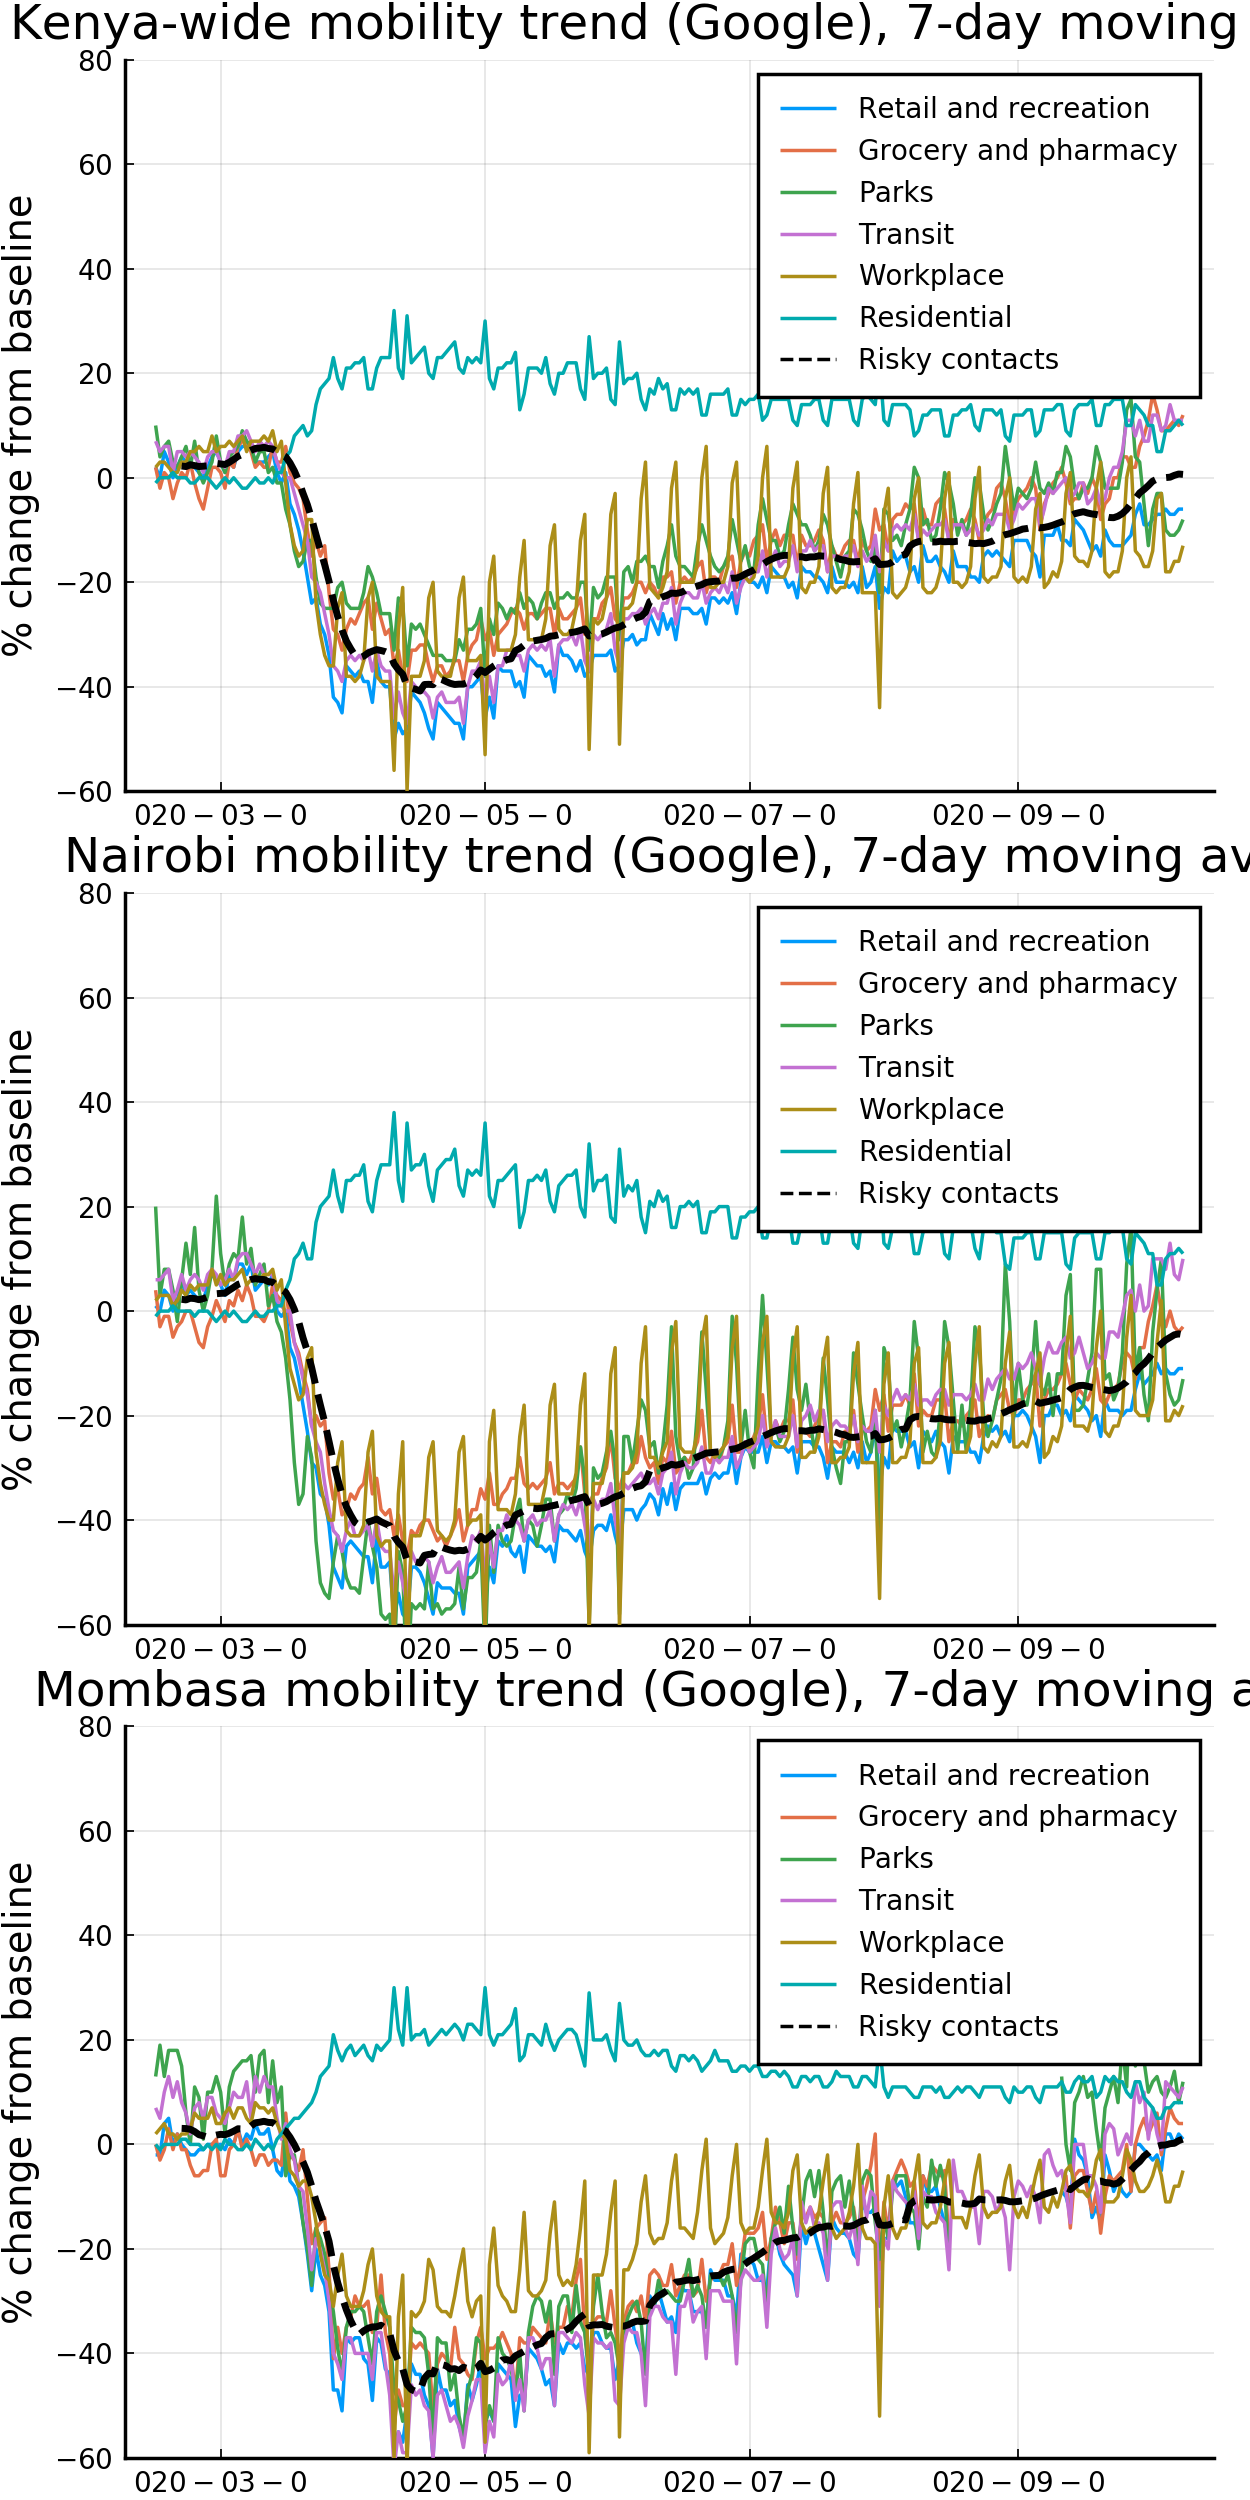

In [19]:
function sma(a::Array, n::Int)
    vals = zeros(size(a,1) - (n-1), size(a,2))

    for i in 1:size(a,1) - (n-1)
        for j in 1:size(a,2)
            vals[i,j] = mean(a[i:i+(n-1),j])
        end
    end

    vals
end

function fillmissingdata_gp(xs,ys,mean_func,kern,obs_noise)
    output_ys = zeros(length(ys))
    #Check if any data is missing
    if any(ismissing.(ys))
        _xs = Float64.(xs[.~ismissing.(ys)])
        _ys = Float64.(ys[.~ismissing.(ys)])
        #Fit a GP
        gp = GP(_xs,_ys,mean_func,kern,obs_noise)
        #Optimise hyperparameters
        GaussianProcesses.optimize!(gp)
        #Fill in missing data using GP predictions
        missing_xs = xs[ismissing.(ys)]
        output_ys[ismissing.(ys)] .= predict_f(gp,missing_xs)[1]
        output_ys[.~ismissing.(ys)] .= Float64.(ys[.~ismissing.(ys)])
    else
        output_ys = Float64.(ys)
    end
    return output_ys
end

#This function implements the data filling
function filledsetting_sma(df::DataFrame,n)
    xs = [Float64.((d - Date(2020,2,20)).value) for d in df.date]

    mZero = MeanZero()                   #Zero mean function
    kern = SE(0.0,7.0)
    logObsNoise = .0

    ys_retail = fillmissingdata_gp(xs,df.retail_and_recreation_percent_change_from_baseline,mZero,kern,logObsNoise)
    ys_grocery = fillmissingdata_gp(xs,df.grocery_and_pharmacy_percent_change_from_baseline,mZero,kern,logObsNoise)
    ys_transit = fillmissingdata_gp(xs,df.transit_stations_percent_change_from_baseline,mZero,kern,logObsNoise)
    ys_workplace = fillmissingdata_gp(xs,df.workplaces_percent_change_from_baseline,mZero,kern,logObsNoise)

    movingavs = sma(hcat(ys_retail,ys_grocery,ys_transit,ys_workplace), n)

    return movingavs
end

#Plotting methods
function riskycontacts_sma(df,n)
    areaname = ""
    if !ismissing(df.sub_region_1[1])
        areaname = df.sub_region_1[1]
    else
        areaname = "Kenyawide"
    end
    risky = filledsetting_sma(df,n)

    return (contactrate = vec(1 .+ mean(risky,dims = 2)./100), date = df.date[n:end], area = areaname)
end
function plot_mobilitytrends(df,title_str,n)
    plt = plot(df.date,Matrix(df[:,9:end]),
        lab = ["Retail and recreation" "Grocery and pharmacy" "Parks" "Transit" "Workplace" "Residential"],
        ylims = (-60,80),
        lw = 1,
        ylabel = "% change from baseline",
        title = title_str,
        size = (300,200),dpi = 250)
    risky_contacts = riskycontacts_sma(df,n)
    plot!(plt,risky_contacts.date,100*risky_contacts.contactrate .- 100,
        lab = "Risky contacts",
        # ylims = (-50,50),
        lw = 2,
        color = :black,
        ls = :dash,
        ylabel = "% change from baseline",
        title = title_str*", $(n)-day moving av.",
        size = (300,200),dpi = 250)
    return plt
end

plt_kenyawide = plot_mobilitytrends(Kenyawide,"Kenya-wide mobility trend (Google)",7);
plt_nairobi = plot_mobilitytrends(nairobidata,"Nairobi mobility trend (Google)",7);
plt_mombasa = plot_mobilitytrends(mombasadata,"Mombasa mobility trend (Google)",7);
layout = @layout [a;b;c]
plt_contact_rate = plot(plt_kenyawide,plt_nairobi,plt_mombasa,layout = layout,
        size = (500,1000),dpi=250)


Transmission of SARS-CoV-2 has been linked to contacts occurring in indoors settings, especially crowded environments. Therefore, in this paper we use an aggregated measure of relative mobility over the "Retail and recreation", "Grocery and pharmacy", "Transit", and "Workplace" settings. This aggregated measure of epidemiologically relevant mobility is projected into the future using a simple linear projection from 1st July. Although, we also assume that the future contact rate will not exceed its 2019 baseline.

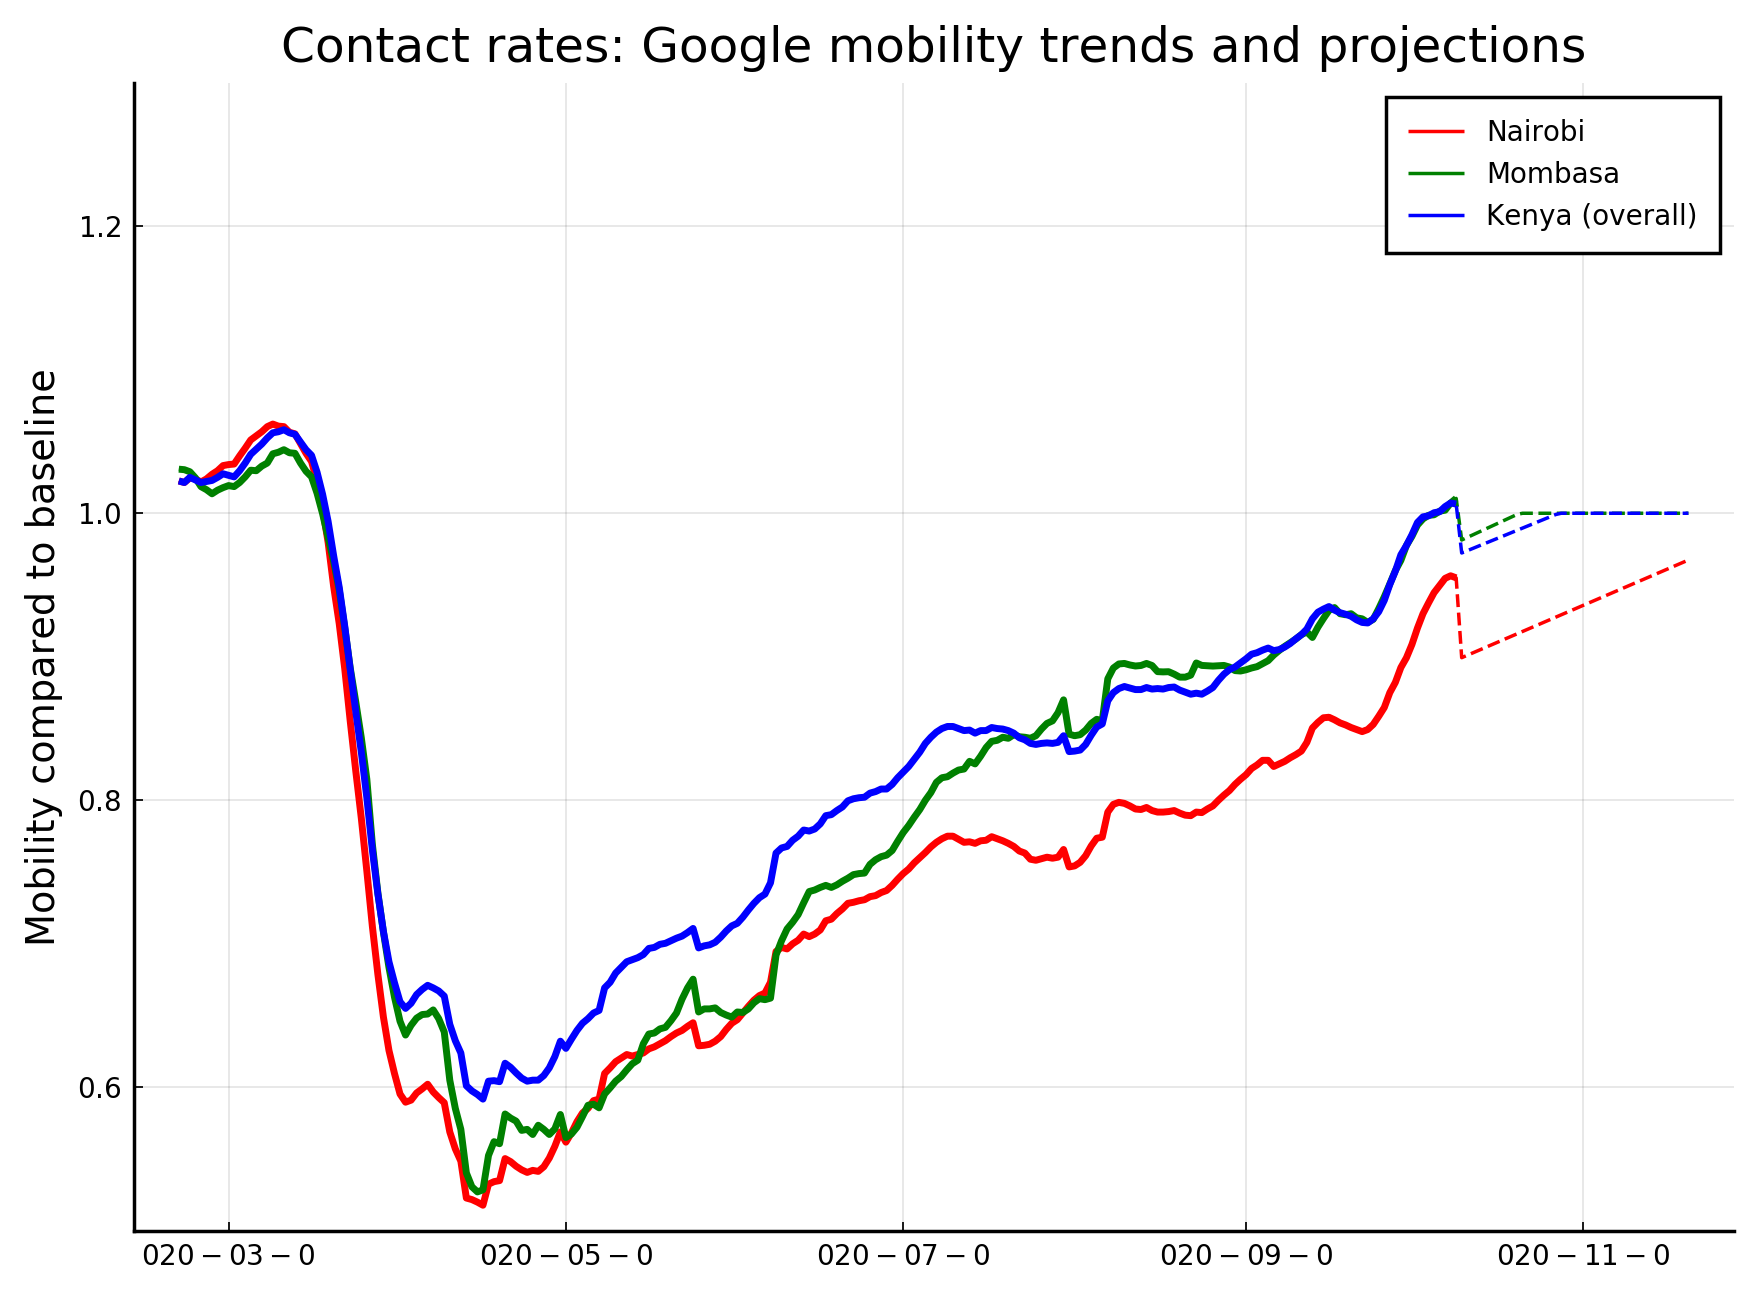

In [20]:
#Methods for doing the aggregation over relevant settings and the 

# function riskycontacts_sma(df,n)
#     areaname = ""
#     if !ismissing(df.sub_region_1[1])
#         areaname = df.sub_region_1[1]
#     else
#         areaname = "Kenyawide"
#     end
#     return (contactrate = 1 .+ sma(mean(Matrix(df[:,[9,10,12,13]]),dims = 2),n)./100, date = df.date[n:end], area = areaname)
# end

function projectcontactrate(contactrate_data,fittingdate::Date,projectiondate::Date)
    f = findfirst(contactrate_nairobi.date .== fittingdate)
    ys = contactrate_data.contactrate[f:end]
    xs = collect(1:length(ys)) .-1
    fit1 = fit(xs,ys,1)
    p = Polynomial(fit1.coeffs)
    _xs = collect((length(ys)+1):((projectiondate - contactrate_nairobi.date[end]).value))
    _ys = [min(1,p(x)) for x in _xs]
    _date = [contactrate_nairobi.date[end] + Day(t) for (t,d) in enumerate(_xs)]
     # vcat(contactrate_data.contactrate,_ys)
     #
     #  vcat(contactrate_data.date,_date)
    return (contactrate = vcat(contactrate_data.contactrate,_ys) , date = vcat(contactrate_data.date,_date), area = contactrate_data.area)
end

#Aggregate over relevant settings, using 7-day moving averages then add projection
contactrate_kenya = riskycontacts_sma(Kenyawide,7)
contactrate_nairobi = riskycontacts_sma(nairobidata,7)
contactrate_mombasa = riskycontacts_sma(mombasadata,7)
projected_contactrate_nairobi = projectcontactrate(contactrate_nairobi,Date(2020,7,1),Date(2021,3,1))
projected_contactrate_mombasa = projectcontactrate(contactrate_mombasa,Date(2020,7,1),Date(2021,3,1))
projected_contactrate_kenya = projectcontactrate(contactrate_kenya,Date(2020,7,1),Date(2021,3,1))



# plot!(contactrate_nairobi.date,contactrate_nairobi.contactrate,lw=2)
plt_mob = plot(projected_contactrate_nairobi.date,projected_contactrate_nairobi.contactrate,
    ls = :dash,
    lab = "",
    color = :red,
    ylims = (0.5,1.3),
    size = (700,500),dpi = 250,
    right_margin = 1cm,
    title = "Contact rates: Google mobility trends and projections",
    ylabel = "Mobility compared to baseline")
plot!(plt_mob,projected_contactrate_mombasa.date,projected_contactrate_mombasa.contactrate,
    ls = :dash,
    lab = "",
    color = :green)
plot!(plt_mob,projected_contactrate_kenya.date,projected_contactrate_kenya.contactrate,
    ls = :dash,
    lab = "",
    color = :blue)

plot!(plt_mob,contactrate_nairobi.date,contactrate_nairobi.contactrate,
    lw = 2,
    lab = "Nairobi",
    color = :red)
plot!(plt_mob,contactrate_mombasa.date,contactrate_mombasa.contactrate,
    lw = 2,
    lab = "Mombasa",
    color = :green)
plot!(plt_mob,contactrate_kenya.date,contactrate_kenya.contactrate,
    lw = 2,
    lab = "Kenya (overall)",
    color = :blue)

# savefig(plt_mob,"Kenyawidemobility_with_projections.pdf")


This is the mobility data we use in the main paper, albeit this includes past the final date in the paper (30th Sept). We either use this directly, or as a prior for fitted contact rates.

When used as a prior we assume that the log-contact rate is *a priori* a Gaussian process, which is fitted to the google data using the `GaussianProcesses.jl` package.

┌ Warning: Attribute alias `color` detected in the user recipe defined for the signature (::GPE{Adjoint{Float64,Array{Float64,1}},Array{Float64,1},MeanZero,SEIso{Float64},GaussianProcesses.FullCovariance,GaussianProcesses.IsotropicData{Array{Float64,2}},PDMats.PDMat{Float64,Array{Float64,2}},GaussianProcesses.Scalar{Float64}}). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots /Users/Sam/.julia/packages/Plots/LWw1t/src/pipeline.jl:15
┌ Warning: Attribute alias `color` detected in the user recipe defined for the signature (::GPE{Adjoint{Float64,Array{Float64,1}},Array{Float64,1},MeanZero,SEIso{Float64},GaussianProcesses.FullCovariance,GaussianProcesses.IsotropicData{Array{Float64,2}},PDMats.PDMat{Float64,Array{Float64,2}},GaussianProcesses.Scalar{Float64}}). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots /Users/Sam/.julia/packages/Plots/LWw1t/src/pipeline.jl:15
┌ Warning: Attribute ali

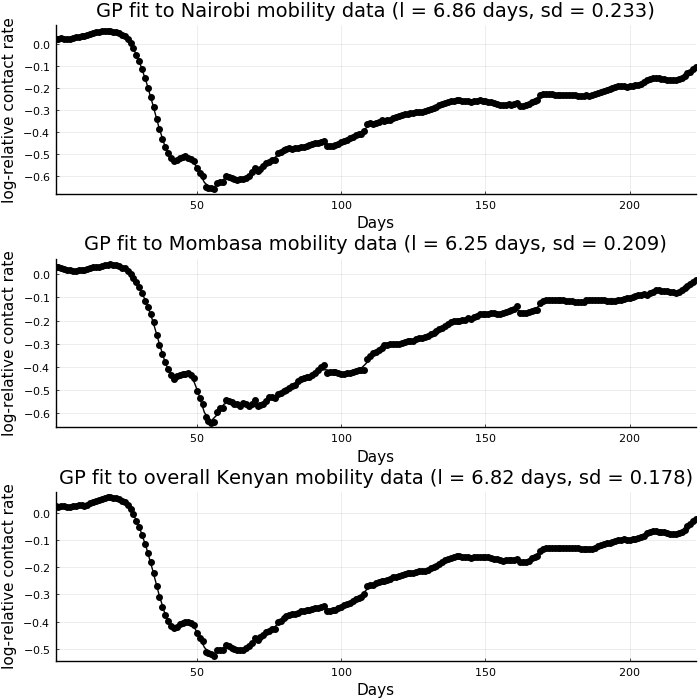

In [30]:
day30sept = (Date(2020,9,30) - Date(2020,2,20)).value

#Fit basic GP for Nairobi log-mobility data, only data upto 30th Sept
ys = log.(projected_contactrate_nairobi.contactrate[1:day30sept])
n = length(ys)
gp_Ct_nai = GPE(collect(1.:1.:n),ys,MeanZero(),SE(log(7),log(0.25)),-5.)
#Optimise length-scale and basic std. dev. hyperparameters
optimize!(gp_Ct_nai)

σ = sqrt(gp_Ct_nai.kernel.σ2) #typical std-dev daily
l = sqrt(gp_Ct_nai.kernel.ℓ2) #typical time scale for auto-correlation

#Fit basic GP for Mombasa log-mobility data, only data upto 30th Sept
ys = log.(projected_contactrate_mombasa.contactrate[1:day30sept])
n = length(ys)
gp_Ct_mom = GPE(collect(1.:1.:n),ys,MeanZero(),SE(log(7),log(0.25)),-5.)
#Optimise length-scale and basic std. dev. hyperparameters
optimize!(gp_Ct_mom)
σ_mom = sqrt(gp_Ct_mom.kernel.σ2) #typical std-dev daily
l_mom = sqrt(gp_Ct_mom.kernel.ℓ2) #typical time scale for auto-correlation

#Fit basic GP for Kenyawide log-mobility data, only data upto 30th Sept
ys = log.(projected_contactrate_kenya.contactrate[1:day30sept])
n = length(ys)
gp_Ct_ken = GPE(collect(1.:1.:n),ys,MeanZero(),SE(log(7),log(0.25)),-5.)
#Optimise length-scale and basic std. dev. hyperparameters
optimize!(gp_Ct_ken)
σ_ken = sqrt(gp_Ct_ken.kernel.σ2) #typical std-dev daily
l_ken = sqrt(gp_Ct_ken.kernel.ℓ2) #typical time scale for auto-correlation

#Plot fit
plt_nai = plot(gp_Ct_nai,
    lab = "",
    title = "GP fit to Nairobi mobility data (l = $(round(l,sigdigits = 3)) days, sd = $(round(σ,sigdigits = 3)))",
    ylabel = "log-relative contact rate",
    xlabel = "Days")

plt_mom = plot(gp_Ct_mom,
    lab = "",
    title = "GP fit to Mombasa mobility data (l = $(round(l_mom,sigdigits = 3)) days, sd = $(round(σ_mom,sigdigits = 3)))",
    ylabel = "log-relative contact rate",
    xlabel = "Days")

plt_ken = plot(gp_Ct_ken,
    lab = "",
    title = "GP fit to overall Kenyan mobility data (l = $(round(l_ken,sigdigits = 3)) days, sd = $(round(σ_ken,sigdigits = 3)))",
    ylabel = "log-relative contact rate",
    xlabel = "Days")

layout = @layout [a;b;c]
plot(plt_nai,plt_mom,plt_ken,layout = layout,size = (700,700))

Each stream of log-mobility data suggests that the correlation length-scale of Kenya log-mobility changes is $\sim 6.8$ days. In the paper, when fitting contact rates we assume that they are *a priori* log-normal with a squared-exponential correlation kernel with length-scale 6.8 days.